In [60]:
# Estos dos comandos evitan que haya que hacer reload cada vez que se modifica un paquete
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
import numpy as np
from matplotlib import pyplot as plt
# from problema_1 import plot_bar_chart
# Importo el paquete para graficar
from matplotlib import pyplot as plt

# Naive bayes - Clasificación

### Bibliografía recomendada
https://nlp.stanford.edu/IR-book/ - Capitulo 13 -  
http://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes

## Ejemplos

![](./images/student-admission.png)

![](./images/chip-test.png)

## Introducción teórica

### Teorema de Bayes
$P(y|x_1,x_2,...,x_n) = \large \frac{P(x_1, x_2,...,x_n|y) P(y)}{P(x_1,x_2,...,x_n)}$

El numerador:

$ \large P(x_1, x_2,...,x_n|y) P(y) = P(y, x_1, x_2,...,x_n)$

Por la regla de la cadena:

$P(x_1,x_2, x_3, y) = P(x_1 | x_2, x_3,y)P(x_2,x_3, y) = P(x_1 | x_2, x_3,y)P(x_2|x_3, y)P(x_3, y) = P(x_1 | x_2, x_3,y)P(x_2|x_3, y)P(x_3| y)P(y)$

$P(x_1,x_2, x_3, y) = P(x_1 | x_2, x_3,y)P(x_2|x_3, y)P(x_3| y)P(y)$

#### Ejemplo con Aplicación SPAM

$\huge P(SPAM| comprar,oferta,ganaste) = \frac{P(comprar | oferta, ganaste,SPAM)P(oferta|ganaste, SPAM)P(ganaste| SPAM)P(SPAM)}{P(comprar, oferta, ganaste)}$

$P(comprar,oferta,ganaste,SPAM) = P(comprar | oferta, ganaste,SPAM)P(oferta|ganaste, SPAM)P(ganaste| SPAM)P(SPAM)$

Asumiendo independencia

$P(x_i|y) = P(x_i|y,x_1,...)$

$P(comprar,oferta,ganaste,SPAM) = P(comprar | SPAM)P(oferta|SPAM)P(ganaste| SPAM)P(SPAM)$

$\huge P(SPAM| comprar,oferta,ganaste) = $  
$\huge  \frac{P(comprar|SPAM)P(oferta|SPAM)P(ganaste| SPAM)P(SPAM)}{P(comprar, oferta, ganaste)}$

### Naive Bayes

$\huge P(y|x_1,x_2,...,x_n) = \huge \frac{P(y)\prod P(x_i/y)} {P(x_1,x_2,...,x_n)} = \alpha {P(y)\prod P(x_i/y)}$

(Compararlo con teorema de Bayes)

$\large \hat{y} = arg max_y [{P(y)\prod P(x_i/y)}]$

Ejemplo SPAM: 

La variable aleatoria $y$ puede ser: [SPAM, NO_SPAM]. Calculo ${P(y)\prod P(x_i/y)}$ para ambos casos y me quedo con el mayor

Como el denominador es el mismo para ambos casos, no hace falta calcularlo

## Detección de SPAM
V. Metsis, I. Androutsopoulos and G. Paliouras (2006). Spam filtering with Naive Bayes – Which Naive Bayes? 3rd Conf. on Email and Anti-Spam (CEAS).
http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=1EEA3C5EE5DDF8409BCC0F09BFB7D98B?doi=10.1.1.61.5542&rep=rep1&type=pdf

Tenemos un dataset donde ya esta preprocesado el texto
- Lemmatization, stemming
- Stop words

In [69]:
from sklearn.feature_extraction.text import CountVectorizer

In [70]:
import os
from collections import Counter
train_dir = './ling-spam/train-mails'
emails = [os.path.join(train_dir,f) for f in os.listdir(train_dir)] 

In [71]:
emails[0:10], len(emails)

(['./ling-spam/train-mails/6-338msg1.txt',
  './ling-spam/train-mails/5-1300msg3.txt',
  './ling-spam/train-mails/6-250msg1.txt',
  './ling-spam/train-mails/6-266msg3.txt',
  './ling-spam/train-mails/spmsgc10.txt',
  './ling-spam/train-mails/5-1326msg1.txt',
  './ling-spam/train-mails/spmsga114.txt',
  './ling-spam/train-mails/spmsga100.txt',
  './ling-spam/train-mails/6-110msg3.txt',
  './ling-spam/train-mails/6-126msg1.txt'],
 702)

In [74]:
m = open(emails[2])
for i,line in enumerate(m):
    print(i, line)
m.close()

0 Subject: re : 6 . 189 innateness / language & specy

1 

2 those interest language species discussion , mention teach undergraduate seminar quarter topic ( call ape language - - cover " ( human ) language ? " " american sign language ? " " train ape ? " evolutionary aspect . ) anyone copy syllabus reading , glad send one . rachel lagunoff ucla



In [75]:
with open(emails[2]) as m:
    print(m)
    for i,line in enumerate(m):
        print(i, line)

<_io.TextIOWrapper name='./ling-spam/train-mails/6-250msg1.txt' mode='r' encoding='UTF-8'>
0 Subject: re : 6 . 189 innateness / language & specy

1 

2 those interest language species discussion , mention teach undergraduate seminar quarter topic ( call ape language - - cover " ( human ) language ? " " american sign language ? " " train ape ? " evolutionary aspect . ) anyone copy syllabus reading , glad send one . rachel lagunoff ucla



In [7]:
def make_Dictionary(train_dir):
    # Train dir es la carpeta para parsear
    emails_array = []
    labels = []
    # Emails es una lista con los nombres de los archivos
    emails = [os.path.join(train_dir,f) for f in os.listdir(train_dir)] 
    # All words contendrá todas las palabras del mail
    all_words = []       
    for mail in emails:
        # mail es el nombre del archivo
        with open(mail) as m:
            # m es el archivo abierto
            if 'spmsg' in mail.split('/')[-1]:
                # Si el nombre del archivo contiene 'spmsg' es spam
                labels.append(True)
            else:
                labels.append(False)
            # email_str va a guardar el mail como string
            email_str = ''
            for i,line in enumerate(m):
                if i == 2:  #Body of email is only 3rd line of text file
                    words = line.split()
                    all_words += words
                    email_str = email_str + ' ' + line
            emails_array.append(email_str)
    dictionary = Counter(all_words)
    return dictionary, emails_array, labels

def remove_uncommon_words(dictionary):
    # Dictionary es un counter
    dict_copy = { k : v for k,v in dictionary.items()}
    list_to_remove = dictionary.keys()
    for item in list_to_remove:
        if item.isalpha() == False: 
            # Remueve lo que no sean palabras con letras del abcedario
            del dict_copy[item]
        elif len(item) == 1:
            # Remueve las palabras de una letra
            del dict_copy[item]
    return Counter(dict_copy)

In [8]:
def read_emails_and_get_dict(folder, max_features=3000):
    dictionary, emails_array, labels = make_Dictionary(folder)
    dictionary = remove_uncommon_words(dictionary)
    dictionary = dictionary.most_common(max_features)
    vocabulary = [key[0] for key in dictionary]
    return vocabulary, emails_array, np.array(labels)

In [83]:
max_features = 3000
vocabulary, emails_array, labels = read_emails_and_get_dict('./ling-spam/train-mails', max_features)
count_vectorizer = CountVectorizer(vocabulary=vocabulary)
feature_matrix = count_vectorizer.fit_transform(emails_array)

In [85]:
feature_matrix

<702x3000 sparse matrix of type '<class 'numpy.int64'>'
	with 82637 stored elements in Compressed Sparse Row format>

In [91]:
1-(feature_matrix != 0).sum()/(702*3000)

0.960761158594492

In [95]:
# feature_matrix.todense()[:, 0]

In [96]:
emails_array[2]

' those interest language species discussion , mention teach undergraduate seminar quarter topic ( call ape language - - cover " ( human ) language ? " " american sign language ? " " train ape ? " evolutionary aspect . ) anyone copy syllabus reading , glad send one . rachel lagunoff ucla\n'

In [97]:
# count_vectorizer.vocabulary_

In [98]:
feature_matrix.shape, labels.shape
# (702, 19571)

((702, 3000), (702,))

In [99]:
labels[:10]

array([False, False, False, False,  True, False,  True,  True, False,
       False])

In [100]:
labels.sum()

351

In [102]:
feature_matrix[labels, :].sum()

98144

In [103]:
feature_matrix[labels, :].sum(axis=0)

(1, 3000)

In [104]:
hist_spam = feature_matrix[labels, :].sum(axis=0)/feature_matrix[labels, :].sum()

In [105]:
hist_spam.shape

(1, 3000)

In [106]:
labels[:5]

array([False, False, False, False,  True])

In [107]:
~labels[:5]

array([ True,  True,  True,  True, False])

In [26]:
len(labels)

702

In [27]:
feature_matrix[~labels, :].shape

(351, 3000)

In [28]:
print(labels[0:10])
print(vocabulary[0:10])
print(feature_matrix)

[False False False False  True False  True  True False False]
['order', 'address', 'report', 'mail', 'send', 'language', 'email', 'program', 'our', 'list']
  (0, 19)	1
  (0, 24)	2
  (0, 273)	1
  (0, 305)	1
  (0, 533)	1
  (0, 562)	1
  (0, 701)	1
  (0, 717)	1
  (0, 1285)	1
  (0, 1418)	1
  (0, 1650)	2
  (1, 1)	2
  (1, 4)	3
  (1, 5)	3
  (1, 6)	2
  (1, 11)	1
  (1, 12)	2
  (1, 16)	1
  (1, 18)	3
  (1, 19)	3
  (1, 22)	1
  (1, 27)	2
  (1, 29)	3
  (1, 31)	3
  (1, 32)	1
  :	:
  (701, 748)	1
  (701, 800)	1
  (701, 865)	1
  (701, 873)	1
  (701, 913)	1
  (701, 919)	1
  (701, 952)	1
  (701, 1017)	1
  (701, 1150)	1
  (701, 1232)	1
  (701, 1263)	1
  (701, 1355)	1
  (701, 1485)	1
  (701, 1486)	1
  (701, 1603)	1
  (701, 1637)	1
  (701, 1816)	1
  (701, 1825)	1
  (701, 1903)	1
  (701, 2362)	1
  (701, 2402)	1
  (701, 2495)	1
  (701, 2672)	2
  (701, 2777)	1
  (701, 2986)	1


In [108]:
print(feature_matrix.sum(axis=0).shape)
print(feature_matrix.sum(axis=0))
print(feature_matrix.sum(axis=0) + 1)
print((feature_matrix.sum(axis=0) + 1).sum())

(1, 3000)
[[1423 1302 1216 ...    8    8    8]]
[[1424 1303 1217 ...    9    9    9]]
157987


In [109]:
def get_histogram_from_matrix(alpha, feature_matrix):
    # Alpha es para suavizar y evitar la probabilidad cero. Normalmente 1
    # Es como agregar un mail con todas las palabras
    words_distribution_un = feature_matrix.sum(axis=0) + alpha
    words_distribution = words_distribution_un/(words_distribution_un.sum()) # + alpha*feature_matrix.shape[1])
    return words_distribution

spam_feature_matrix = feature_matrix[labels,:]
ham_feature_matrix = feature_matrix[np.logical_not(labels),:]

print('SPAM:',labels.nonzero()[0].shape[0],
      'HAM:',np.logical_not(labels).nonzero()[0].shape[0],
      'total:',len(labels))

print()
print('Palabras diferentes')
print('SPAM:', spam_feature_matrix.nonzero()[0].shape[0],
      'HAM:',ham_feature_matrix.nonzero()[0].shape[0])

print()
print('Cantidad de palabras')
print('SPAM:',spam_feature_matrix.sum(), 'HAM:',ham_feature_matrix.sum())


# P(x_i/SPAM)
spam_words_distribution = get_histogram_from_matrix(1, spam_feature_matrix)
# P(x_i/HAM)
ham_words_distribution = get_histogram_from_matrix(1, ham_feature_matrix)

SPAM: 351 HAM: 351 total: 702

Palabras diferentes
SPAM: 49290 HAM: 33347

Cantidad de palabras
SPAM: 98144 HAM: 56843


$\hat{y} = arg max_y [{P(y)\prod P(x_i/y)}]$

$y = [SPAM, HAM]$

In [110]:
def plot_bar_chart(P, vocabulary = None, title='title', show_graph=False):
    N = len(P)
    if show_graph:
        plt.figure(figsize=(20, 5)) # Tamaño del gráfico
    indexes = list(range(1, len(P) + 1))
    plt.bar(indexes, P, width=0.75, alpha=0.5, label=title) # Grafico
#     plt.title(title)

    # Definición de indices
    if not vocabulary:
        string_indexes = [str(i) for i in indexes]
    else:
        string_indexes = [vocabulary[i-1] for i in indexes]
    plt.xlim([0,N+1])
    plt.xticks(indexes, string_indexes, fontsize=24) 
    plt.xticks(rotation=80)
    if show_graph:
        plt.show()

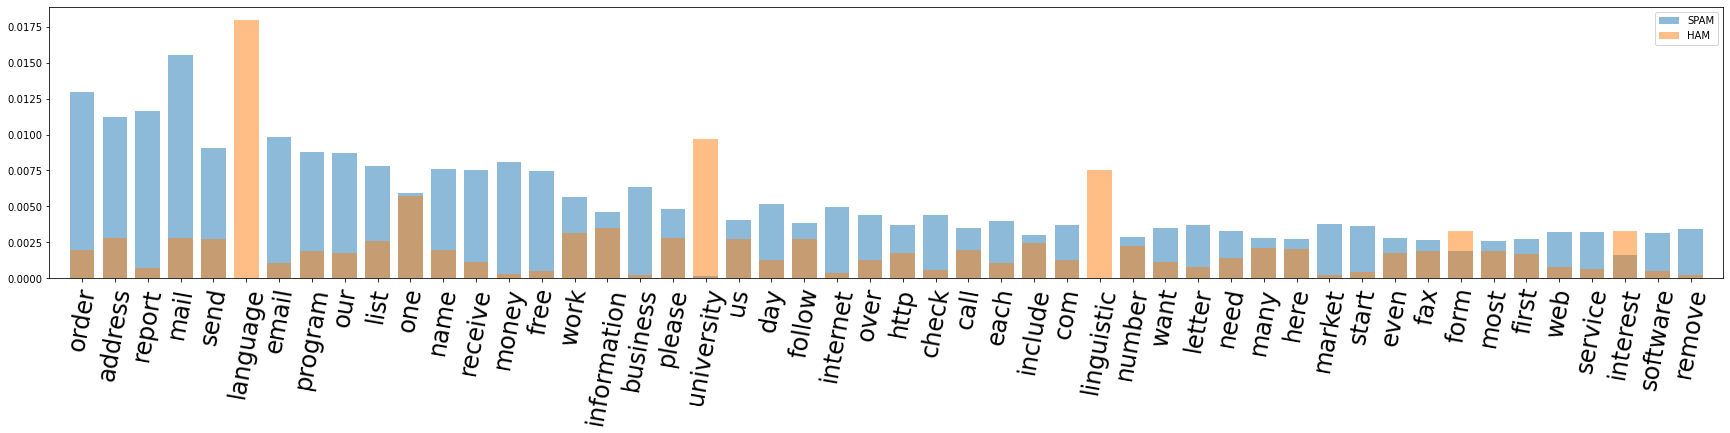

In [122]:
plt.figure(figsize=(30, 5))
N = 50
plot_bar_chart(np.array(spam_words_distribution)[0][:N],
               vocabulary = vocabulary,
               title='SPAM')
plot_bar_chart(np.array(ham_words_distribution)[0][:N],
               vocabulary = vocabulary,
               title='HAM')
plt.legend()

In [124]:
spam_words_distribution

matrix([[1.29419442e-02, 1.12315115e-02, 1.16269873e-02, ...,
         3.95475757e-05, 4.94344697e-05, 1.97737879e-05]])

In [125]:
ham_words_distribution

matrix([[1.93840549e-03, 2.80734589e-03, 7.01836472e-04, ...,
         1.00262353e-04, 8.35519610e-05, 1.33683138e-04]])

In [119]:
np.array(vocabulary)

array(['order', 'address', 'report', ..., 'fear', 'preparation', 'extent'],
      dtype='<U21')

In [120]:
non_zero_row

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([  19,   24,  273,  305,  533,  562,  701,  717, 1285, 1418, 1650],
       dtype=int32))

In [126]:
# np.array(vocabulary)[[1, 2, 5]]

In [127]:
non_zero_row

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([  19,   24,  273,  305,  533,  562,  701,  717, 1285, 1418, 1650],
       dtype=int32))

$\large \hat{y} = arg max_y [{P(y)\prod P(x_i/y)}]$

In [128]:
# Veamos si el primer email es SPAM o no
# El primer mail corresponde a la primer fila de la matriz
idx = 0
row = feature_matrix[idx,:]

non_zero_row = row.nonzero()
print('Email preprocesado:', emails_array[idx])
print('Palabras:', np.array(vocabulary)[non_zero_row[1]])
print('Primer email codificado:')
print(row)
print('Elementos distintos de cero:',non_zero_row[1])
print('Producto, no es necesario [P(Y) = P(SPAM) = P(HAM)] por que es para ambos casos igual. Lo mismo el denominador')
print(np.power(spam_words_distribution[non_zero_row], feature_matrix[non_zero_row]).prod())
print(np.power(ham_words_distribution[non_zero_row], feature_matrix[non_zero_row]).prod())
print('Log likelihood')
print(np.log(spam_words_distribution[non_zero_row])*feature_matrix[non_zero_row].T)
print(np.log(ham_words_distribution[non_zero_row])*feature_matrix[non_zero_row].T)

Email preprocesado:  n't quite qualify , ' overlook ' means opposite ' over ' : " accountant over record overlook deduction . . . " - - - university californium riverside , ca 92521

Palabras: ['university' 'over' 'ca' 'record' 'means' 'quite' 'qualify' 'californium'
 'opposite' 'accountant' 'overlook']
Primer email codificado:
  (0, 19)	1
  (0, 24)	2
  (0, 273)	1
  (0, 305)	1
  (0, 533)	1
  (0, 562)	1
  (0, 701)	1
  (0, 717)	1
  (0, 1285)	1
  (0, 1418)	1
  (0, 1650)	2
Elementos distintos de cero: [  19   24  273  305  533  562  701  717 1285 1418 1650]
Producto, no es necesario [P(Y) = P(SPAM) = P(HAM)] por que es para ambos casos igual. Lo mismo el denominador
6.445539154956255e-47
2.3514539425668175e-43
Log likelihood
[[-106.35811108]]
[[-98.15612516]]


In [129]:
np.array(vocabulary)[non_zero_row[1]]

array(['university', 'over', 'ca', 'record', 'means', 'quite', 'qualify',
       'californium', 'opposite', 'accountant', 'overlook'], dtype='<U21')

In [130]:
emails_array[0]

' n\'t quite qualify , \' overlook \' means opposite \' over \' : " accountant over record overlook deduction . . . " - - - university californium riverside , ca 92521\n'

¿Por que usamos log likelihood?

In [131]:
def get_accuracy(feature_matrix, labels, spam_words_distribution, ham_words_distribution):
    P_SPAM = labels.nonzero()[0].shape[0]/len(labels) # Por que no es necesario en este caso?
    P_HAM = np.logical_not(labels).nonzero()[0].shape[0]/len(labels) # Por que no es necesario en este caso?
    correct_count = 0
    for i, row in enumerate(feature_matrix):
        coded_email = row.nonzero()
        spam_prod = np.log(spam_words_distribution[coded_email]) * feature_matrix[i][coded_email].T
        ham_prod = np.log(ham_words_distribution[coded_email]) * feature_matrix[i][coded_email].T
        spam_log_likelihood = spam_prod + np.log(P_SPAM)
        ham_log_likelihood = ham_prod + np.log(P_HAM)
        SPAM = spam_log_likelihood>=ham_log_likelihood
        if SPAM == labels[i]:
            correct_count = correct_count + 1
    print('%0.3f'%(correct_count/len(labels)))

In [133]:
get_accuracy(feature_matrix, labels, spam_words_distribution, ham_words_distribution)

0.990


## Test set

In [134]:
_, emails_array, labels_test = read_emails_and_get_dict('./ling-spam/test-mails', max_features)
count_vectorizer_test = CountVectorizer(vocabulary=vocabulary)
feature_matrix_test = count_vectorizer.fit_transform(emails_array)

In [135]:
get_accuracy(feature_matrix_test, labels_test, spam_words_distribution, ham_words_distribution)

0.962


# Sklearn MultinomialNB

In [137]:
from sklearn.naive_bayes import MultinomialNB

In [142]:
clf = MultinomialNB(alpha=1, class_prior=[0.5, 0.5], fit_prior=False)

In [146]:
clf.feature_count_

array([[1.150e+02, 1.670e+02, 4.100e+01, ..., 5.000e+00, 4.000e+00,
        7.000e+00],
       [1.308e+03, 1.135e+03, 1.175e+03, ..., 3.000e+00, 4.000e+00,
        1.000e+00]])

In [144]:
clf.fit(feature_matrix, labels)

MultinomialNB(alpha=1, class_prior=[0.5, 0.5], fit_prior=False)

In [147]:
print(clf.feature_log_prob_.shape)
print(clf.feature_count_.shape)
print(clf.class_log_prior_.shape)
print(clf.class_prior)

(2, 3000)
(2, 3000)
(2,)
[0.5, 0.5]


In [148]:
clf.score(feature_matrix, labels)

0.99002849002849

In [149]:
clf.score(feature_matrix_test, labels_test)

0.9615384615384616

In [45]:
print(clf.predict(feature_matrix_test[100:110]))

[False False  True False  True  True  True  True False False]


In [150]:
print(clf.predict_proba(feature_matrix_test[100:110])[:,1])

[4.32577416e-203 9.25701855e-168 1.00000000e+000 9.54021707e-106
 1.00000000e+000 1.00000000e+000 9.99990147e-001 1.00000000e+000
 2.04412793e-077 7.70903147e-057]


In [167]:
train_scores = []
test_scores = []
for alpha in [0.001, 0.2, 0.5, 1, 1.5, 2, 5, 10, 20, 40, 50, 100]:
    clf = MultinomialNB(alpha=alpha, class_prior=[0.5, 0.5], fit_prior=False)
    clf.fit(feature_matrix, labels)
    test_scores.append(clf.score(feature_matrix_test, labels_test))
    train_scores.append(clf.score(feature_matrix, labels))
    

In [168]:
test_scores

[0.9615384615384616,
 0.9615384615384616,
 0.9615384615384616,
 0.9615384615384616,
 0.9615384615384616,
 0.9615384615384616,
 0.9615384615384616,
 0.9653846153846154,
 0.9615384615384616,
 0.9576923076923077,
 0.9576923076923077,
 0.95]

# Sklearn BernoulliNB
Suele ser interesante evaluar Multinomial y Bernoulli para comparar resultados. A veces para textos cortos BernoulliNB puede dar mejores resultados

In [175]:
from sklearn.naive_bayes import BernoulliNB

In [170]:
clf_Ber = BernoulliNB(alpha=1, class_prior=[0.5, 0.5], fit_prior=False, binarize=0.5)

In [153]:
clf_Ber.fit(feature_matrix, labels)

BernoulliNB(alpha=1, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)

In [154]:
clf_Ber.score(feature_matrix, labels)

0.8603988603988604

In [155]:
clf_Ber.score(feature_matrix_test, labels_test)

0.7653846153846153

In [172]:
train_scores = []
test_scores = []
for alpha in [0.001, 0.2, 0.5, 1, 1.5, 2, 5, 10, 20, 40, 50, 100]:
    clf = BernoulliNB(alpha=alpha, class_prior=[0.5, 0.5], fit_prior=False)
    clf.fit(feature_matrix, labels)
    test_scores.append(clf.score(feature_matrix_test, labels_test))
    train_scores.append(clf.score(feature_matrix, labels))
    

In [174]:
test_scores

[0.8384615384615385,
 0.7923076923076923,
 0.7769230769230769,
 0.7653846153846153,
 0.7653846153846153,
 0.7653846153846153,
 0.75,
 0.7038461538461539,
 0.6846153846153846,
 0.6692307692307692,
 0.6538461538461539,
 0.6192307692307693]

# ¿Es posible graficar un problema de dimensión 3000 en 2 dimensiones?

In [176]:
feature_matrix.shape

(702, 3000)

In [179]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
fmd = feature_matrix.todense()
svd = TruncatedSVD(n_components=8, n_iter=200, random_state=42)
svd.fit(fmd.T)
X_embedded = TSNE(n_components=2).fit_transform(svd.components_.T)

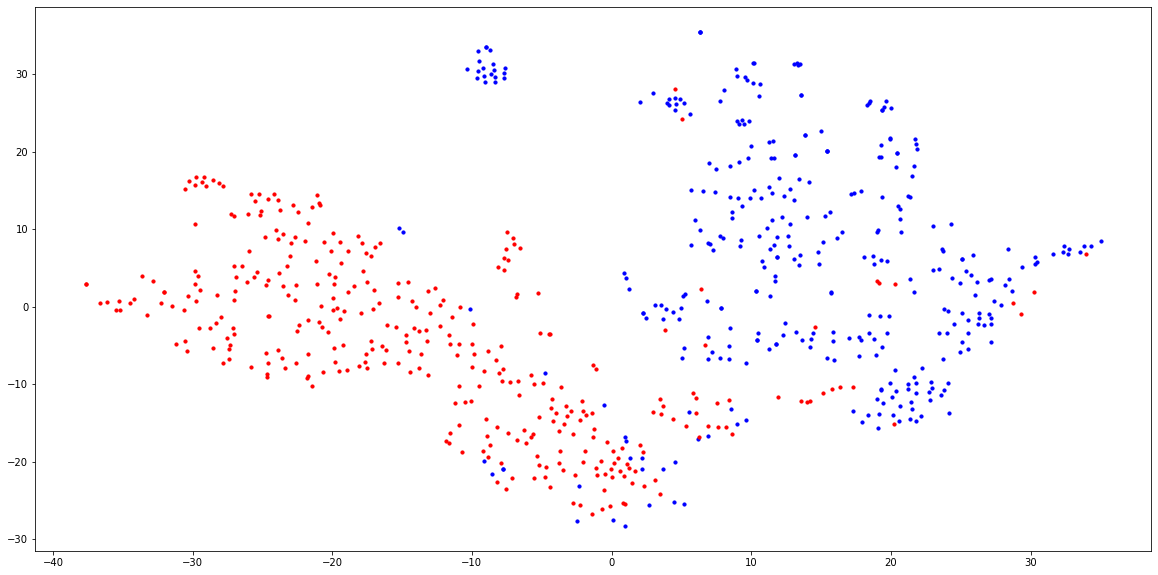

In [180]:
plt.figure(figsize=(20,10))
plt.scatter(X_embedded[labels,0], X_embedded[labels,1], color='b', s=10)
plt.scatter(X_embedded[np.logical_not(labels),0], X_embedded[np.logical_not(labels),1], color='r', s=10)
plt.show()

In [181]:
fmd.shape

(702, 3000)

In [182]:
from sklearn.decomposition import PCA

In [183]:
pca = PCA(n_components=2)
X_new = pca.fit_transform(fmd)

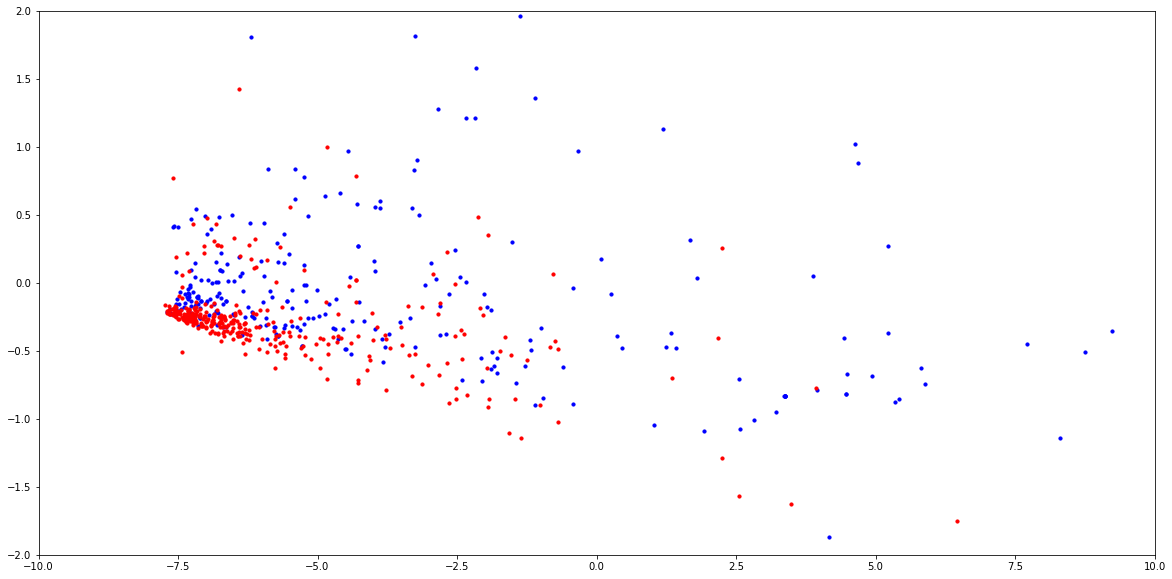

In [184]:
plt.figure(figsize=(20,10))
plt.scatter(X_new[labels,0], X_new[labels,1], color='b', s=10)
plt.scatter(X_new[np.logical_not(labels),0], X_new[np.logical_not(labels),1], color='r', s=10)
plt.ylim([-2,2])
plt.xlim([-10,10])
plt.show()